In [1]:
import findspark
findspark.init("/home/yamhiroto/spark-2.3.4-bin-hadoop2.7")

import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import time as time
from matplotlib.patches import Rectangle
import datetime


### Problem Definition

The dataset I use is collected from The U.S. Department of Transportation’s (DOT) Bureau of Transportation Statistics, which contains more than 5 million records of the flights’ information during 2015, including the carrier of the airline, the original airport, destination airport, the distance of the flight, the time spent, the departure delay time, and arrival delay time, etc. 

I will use this dataset to train a model to predict if a flight will be delayed or not. 

In [3]:
# Instantiate a spark session
sc = SparkContext()
spark = SparkSession.builder.master('local[*]').appName('flights_delay').config('spark.driver.memory', '8g').getOrCreate()

### DATA CLEANING

In [80]:
# load raw data
df = spark.read.csv('datasets/flights.csv', header=True,
                    inferSchema=True, nullValue='')

In [81]:
df.columns

['YEAR',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'AIRLINE',
 'FLIGHT_NUMBER',
 'TAIL_NUMBER',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT',
 'SCHEDULED_DEPARTURE',
 'DEPARTURE_TIME',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'SCHEDULED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'WHEELS_ON',
 'TAXI_IN',
 'SCHEDULED_ARRIVAL',
 'ARRIVAL_TIME',
 'ARRIVAL_DELAY',
 'DIVERTED',
 'CANCELLED',
 'CANCELLATION_REASON',
 'AIR_SYSTEM_DELAY',
 'SECURITY_DELAY',
 'AIRLINE_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'WEATHER_DELAY']

In [82]:

selected_columns= ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
           'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'TAXI_OUT',
           'SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', 'DISTANCE',
           'SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY']

df = df.select(selected_columns)

df = df.dropna()

In [ ]:
df.groupBy('label').count().collect()

In [83]:
df.count()

5714008

### DATA ANALYSIS

In [84]:
#number of origin airports and destination airports
num_src_airport = df.select('ORIGIN_AIRPORT').distinct().count()
num_dest_airport = df.select('DESTINATION_AIRPORT').distinct().count()
print("number of origin airports ", num_src_airport)
print("number of destination airports ", num_src_airport)

#number of carrier
num_carrier =df.select('AIRLINE').distinct().count()
print("number of carrier", num_carrier)

#number of night flight in 2015
night_flights = df.filter(df.SCHEDULED_DEPARTURE>1800).distinct().count()
print("the number of night flights:", night_flights)


number of origin airports  628
number of destination airports  628
number of carrier 14
the number of night flights: 1221750


In [94]:
#number of flight per month in 2015
statistic_month = df.groupBy("month").count().collect()

# calculate the delay ratio each month
statistic_month_delay = df.groupBy("month")\
                                .agg((func.sum('label')/count('*'))\
                                .alias('delay_ratio')).orderBy("month").collect()

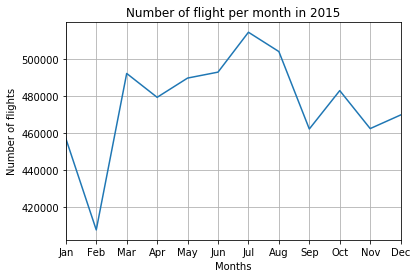

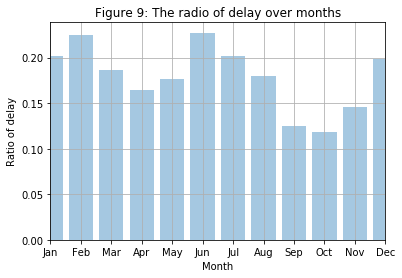

In [95]:
#plot graph

pdf = pd.DataFrame(data=statistic_month).sort_values(by=0, ascending = True) #by=0 to choose column with months
plt.xlabel("Months")
plt.ylabel("Number of flights")
plt.title('Number of flight per month in 2015')
plt.grid(True,which="both",ls="-")
plt.plot(pdf[0], pdf[1])
plt.xlim(1,12)
plt.xticks(range(1,13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()


pdf_month = pd.DataFrame(data=statistic_month_delay)
plt.bar(pdf_month[0], pdf_month[1], align="center", alpha=0.4)
plt.grid(True,which="both",ls="-")
plt.xlabel("Month")
plt.ylabel("Ratio of delay")
plt.xlim(1,12)
plt.title('Delay ratio per month in 2015')
plt.xticks(range(1,13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

**Comments** Peaks are in June, July, August (Summer holiday) and December-January (Winter Holiday)

In [96]:
#number of flight per day of the week 
statistic_day_of_week = df.groupBy("DAY_OF_WEEK").count().collect()


# calculate the delay ratio in each day of week
statistic_day_of_week_delay = (df.groupBy("DAY_OF_WEEK")\
                         .agg((sum('label')/count('*')).alias('delay_ratio'))\
                         .orderBy("DAY_OF_WEEK").collect()\
                        )


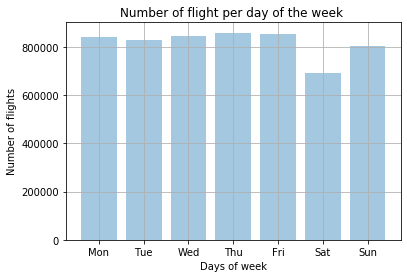

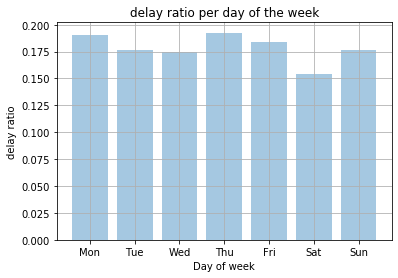

In [97]:
# collect data and plot
pdf = pd.DataFrame(data=statistic_day_of_week)
plt.xlabel("Days of week")
plt.ylabel("Number of flights")
plt.title('Number of flight per day of the week ')
plt.grid(True,which="both",ls="-")
map_int_into_day = { 1:"Mon", 2:"Tue", 3:"Wed", 4:"Thu", 5:"Fri", 6:"Sat", 7:"Sun" }
day_of_week_label = pdf[0].map(lambda i: map_int_into_day[i])

plt.bar(pdf[0], pdf[1], align="center", alpha = 0.4)
plt.xticks(pdf[0], day_of_week_label)
plt.show()


pdf_day_of_week = pd.DataFrame(data=statistic_day_of_week_delay)
map_int_into_day = { 1:"Mon", 2:"Tue", 3:"Wed", 4:"Thu", 5:"Fri", 6:"Sat", 7:"Sun" }
day_of_week_label = pdf_day_of_week[0].map(lambda i: map_int_into_day[i])

plt.bar(pdf_day_of_week[0], pdf_day_of_week[1], align="center", alpha=0.4)
plt.grid(True,which="both",ls="-")
plt.xlabel("Day of week")
plt.ylabel("delay ratio")
plt.title('delay ratio per day of the week')
plt.xticks(pdf_day_of_week[0], day_of_week_label)
plt.show()

In [105]:
stat_carrier = (df
                .groupBy("AIRLINE")
                .agg(count("*").alias('count'))
                .orderBy(desc('count'))
                ).collect()


In [106]:
statistic_ratio_delay_carrier = (df.groupBy("AIRLINE")\
                                 .agg((sum('label')/count('*'))\
                                 .alias('delay_ratio'))\
                                 .orderBy("AIRLINE")
                                ).collect()

/home/yamhiroto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing 'normal' to axis() is deprecated since 3.1; use 'auto' instead.
  app.launch_new_instance()


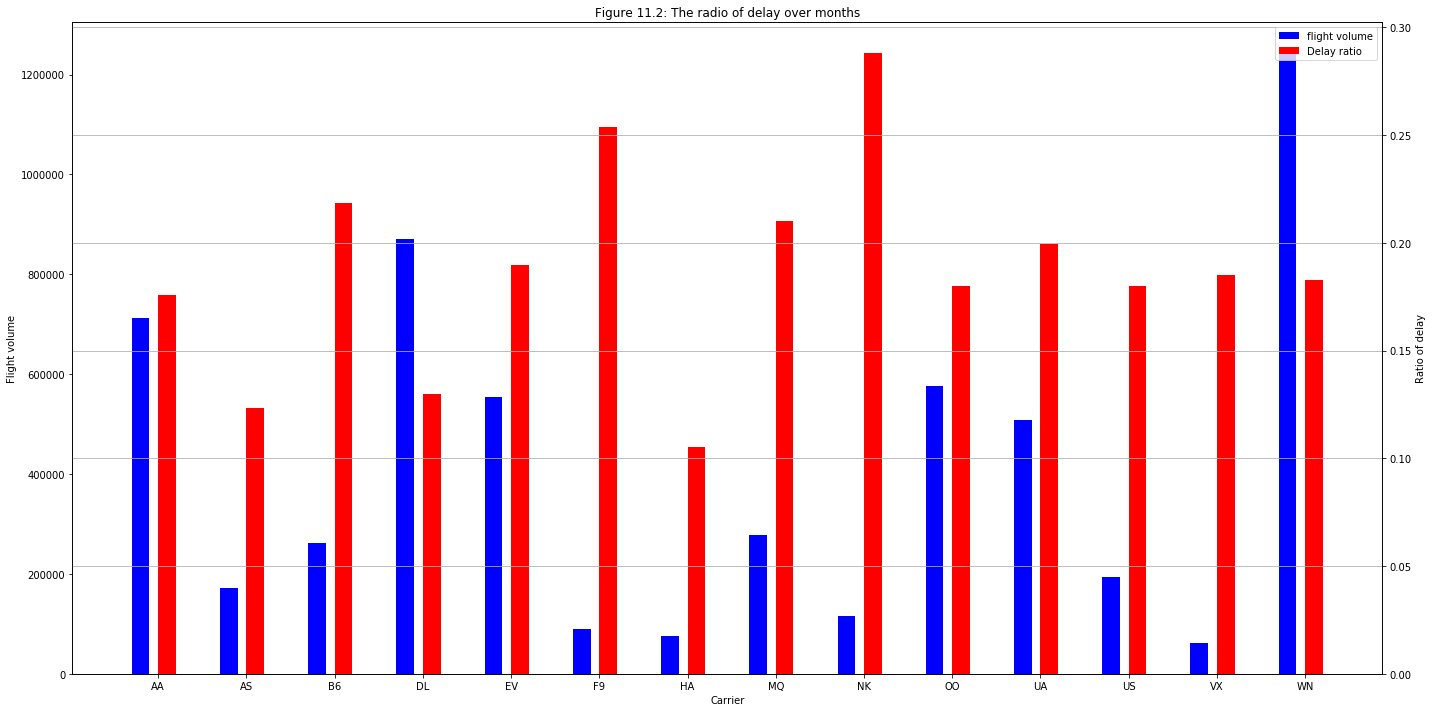

In [120]:
# collect data and plot
pdf_ratio_delay_carrier = pd.DataFrame(data=statistic_ratio_delay_carrier)
pdf_carrier_volume = pd.DataFrame(data=stat_carrier, columns=['AIRLINE', 'count']).sort_values(by='AIRLINE')

#print(pdf_carrier_volume)
stat_carrier.sort()
index = np.arange(len(stat_carrier))
bar_width = 0.2
opacity = 0.4


fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)

ax2 = ax.twinx()
plt.axis('normal')
ax.set_xlabel("Carrier")
ax.set_ylabel("Flight volume")
ax2.set_ylabel("Ratio of delay")
plt.xticks(index + bar_width, pdf_carrier_volume.AIRLINE)

plt.title('Figure 11.2: The radio of delay over months')
plt.grid(True,which="both",ls="-")
bar = ax.bar(index, pdf_carrier_volume['count'], 
        bar_width, color='b', 
        label='flight volume')
bar2 = ax2.bar(index + 1.5*bar_width, pdf_ratio_delay_carrier[1], bar_width, 
       align='center', color='r', 
       label='Delay ratio')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.tight_layout()
plt.show()

### DATA SEGREGATION


We will now build the model. Since out problem is to predict whether a flight will be delayed or not, it is a binary classification problem, I choose:
- a decision tree classification model
- the random forest classification model
- logistic regression model

In [16]:
# create training and test set
flights_train, flights_test = df.randomSplit([.8, .2], 5)

### create the machine learning pipeline 

Step1 - Convert all the categorical data in the dataset into numerical data (since the underlying machine is more familiar with numbers than text) : For the flights dataset, we have three categorical columns: AIRLINE, ORIGINAL_AIRPORT and DESTINATION_AIRPORT. Therefore,we construct three StringIndexer objects.

Step2 -  The OneHotEncoderEstimator object will convert all the categorical columns into their corresponding numerical columns with sparse vector representations(a sparse vector representation is a more efficient way to represent a vector if the majority of the vector column is zero values)

Step 3 - the VectorAssembler will allow us to merge all the sparse vectors and other numerical values in the dataset into a single sparse vector, by concatenating them one by one and call this new vector "features"


In [17]:
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler

#Step 1
airline_indexer=StringIndexer(inputCol='AIRLINE',outputCol='AIRLINE_index').setHandleInvalid("keep")
origin_indexer=StringIndexer(inputCol='ORIGIN_AIRPORT',outputCol='ORG_AIRPT_index').setHandleInvalid("keep")
destination_indexer =StringIndexer(inputCol='DESTINATION_AIRPORT', outputCol='DEST_AIRPT_index').setHandleInvalid("keep")


#Step 2
onehot  = OneHotEncoderEstimator(inputCols=[airline_indexer.getOutputCol(), origin_indexer.getOutputCol(), destination_indexer.getOutputCol()],\
                                 outputCols=['airport_dummy', 'origin_dummy','destination_dummy'])

#Step 3
assembler = VectorAssembler(inputCols=['MONTH', 'DAY', 'DAY_OF_WEEK','airport_dummy', 'origin_dummy', 'destination_dummy','SCHEDULED_DEPARTURE','TAXI_OUT','DEPARTURE_DELAY', 'DISTANCE','SCHEDULED_ARRIVAL'],\
                            outputCol='features')

In [31]:
#use of a Decision tree classifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline


dt = DecisionTreeClassifier(labelCol='label',featuresCol='features')

pipeline=Pipeline(stages=[airline_indexer,origin_indexer,destination_indexer,onehot,assembler,dt])

model_dt=pipeline.fit(flights_train)

prediction_dt = model_dt.transform(flights_test)

prediction_dt.select("prediction","label","features").show(5)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|    1|(1276,[0,1,2,5,19...|
|       1.0|    1|(1276,[0,1,2,5,21...|
|       1.0|    1|(1276,[0,1,2,5,33...|
|       0.0|    0|(1276,[0,1,2,5,23...|
|       1.0|    1|(1276,[0,1,2,5,19...|
+----------+-----+--------------------+
only showing top 5 rows



In [122]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction_dt)
print("Test Error = %g " % (1.0 - accuracy))

TypeError: __init__() got an unexpected keyword argument 'predictionCol'

In [20]:
#use of a Random Forest Classifier

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

rf = RandomForestClassifier(labelCol='label',featuresCol='features',numTrees=30, maxDepth=30)

pipeline=Pipeline(stages=[airline_indexer,origin_indexer,destination_indexer,onehot,assembler,rf])

In [21]:
#use of Logistic Regression Model

from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
lr = LogisticRegression(maxIter=30)
pipeline = Pipeline(stages=[airline_indexer,origin_indexer,destination_indexer,onehot,assembler,lr])

In [24]:
#During training, it is common practice to implement K-fold Cross-validation and Grid Search.
#Code for the Random Forest Classifier:

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
param = ParamGridBuilder().build()

from pyspark.ml.evaluation import BinaryClassificationEvaluator

#initialize the evaluator
evaluator = BinaryClassificationEvaluator()

cv = CrossValidator(estimator = pipeline, estimatorParamMaps = param, evaluator = evaluator, numFolds = 5)


#Code for the Logistic Regression CLassifier:
#params = ParamGridBuilder()

#regParam is the regularization coefficient which specifies that, in the range of 0.01 to 10, how much the model should be regularized.(the bigger the number, the more the model is regularized).
#elasticNEtParam specifies the way the model is regularized, 0 means it's an L2 penalty and 1 means it's an L1 penalty. 0.5 means the penalty is a combination of both L1 and L2
#params = params.addGrid(lr.regParam, [.01,.1,1,10]).addGrid(lr.elasticNetParam, [0, .5, 1])
#params = params.build()
#cv = CrossValidator(estimator = pipeline, estimatorParamMaps = params, evaluator = evaluator, numFolds = 5 )

In [25]:
#for a binary classification problem, it is common practice to evaluate the performance of the model by plotting the roc (Reciver Operating Characteristic) curce or calculating precision, recall, and F1-scores.

#For randomForest classifier and logistic Regression model, we will use the following code to calculate the AUC (area under ROC curve), precesion and recall.


#train the model
cv =cv.fit(flights_train)

#get the prediction
prediction = cv.transform(flights_test)

#calculate AUC

auc = evaluator.evaluate(prediction, {evaluator.metricName:'areaUnderROC'})
print(f'AUC: {auc}')

#compute TN,TP,FN,FP
prediction.groupBy('label','prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label <> prediction').count()
FP = prediction.filter('prediction = 1 AND label <> prediction').count()

# calculate accuracy, precision, recall, and F1-score
accuracy = (TN + TP) / (TN + TP + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F =  2 * (precision*recall) / (precision + recall)

print('n precision: %0.3f' % precision)
print('n recall: %0.3f' % recall)
print('n accuracy: %0.3f' % accuracy)
print('n F1 score: %0.3f' % F)

AUC: 0.9677873817592777
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       0.0| 20520|
|    0|       0.0|190382|
|    1|       1.0|184484|
|    0|       1.0| 13918|
+-----+----------+------+

n precision: 0.930
n recall: 0.900
n accuracy: 0.916
n F1 score: 0.915


In [28]:
from pyspark.ml.evaluation import RegressionEvaluator

# Select example rows to display.
prediction.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(prediction)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|    1|(1276,[0,1,2,5,19...|
|       1.0|    1|(1276,[0,1,2,5,21...|
|       1.0|    1|(1276,[0,1,2,5,33...|
|       0.0|    0|(1276,[0,1,2,5,23...|
|       1.0|    1|(1276,[0,1,2,5,19...|
+----------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.290065
